<a href="https://colab.research.google.com/github/Sunny1729-prog/Data-Science-and-Machine-Learning/blob/main/Mini_Project3(Name%3DSunny_Kumar)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

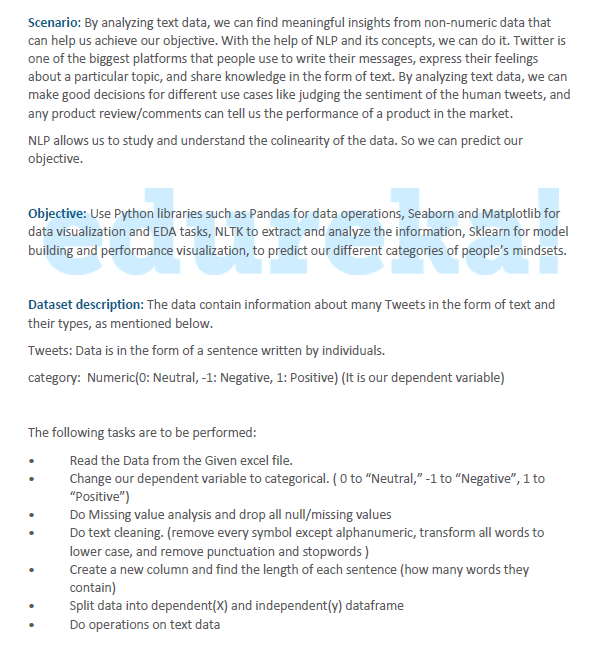
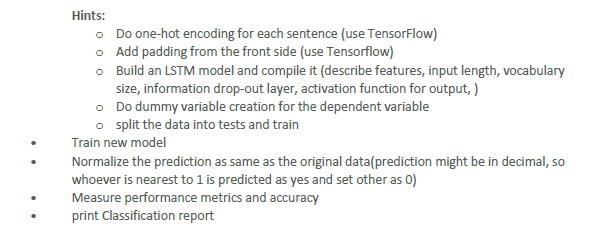

In [ ]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout,Input,GlobalMaxPooling1D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import imdb
from keras.preprocessing import sequence
from sklearn.svm import LinearSVC
from keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import string
import spacy
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = pd.read_csv("/content/Twitter_Data.csv")
data.tail()

,clean_text,category
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0
162979,have you ever listen about like gurukul where ...,1.0


In [ ]:
data.shape

(162980, 2)

In [ ]:
data.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.isnull().sum()

clean_text    0
category      0
dtype: int64

In [ ]:
data.dtypes

clean_text     object
category      float64
dtype: object

In [ ]:
dt = { "category" : { -1 : "negative", 0 : "neutral", 1 : "positive"}}
data=data.replace(dt)

In [ ]:
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [ ]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
data['clean_text'] = data['clean_text'].apply(clean)

In [ ]:
MAX_NB_WORDS = 80000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['clean_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 121148 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['clean_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162969, 250)


In [ ]:
Y = pd.get_dummies(data['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (162969, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(146672, 250) (146672, 3)
(16297, 250) (16297, 3)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.25))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          10240000  
                                                                 
 dropout (Dropout)           (None, 250, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 10,331,903
Trainable params: 10,331,903
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping

history = model.fit(X_train, Y_train, epochs=5,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

Epoch 1/5
2063/2063 [==============================] - 2138s 1s/step - loss: 0.4456 - accuracy: 0.8386 - val_loss: 0.3152 - val_accuracy: 0.9008
Epoch 2/5
2063/2063 [==============================] - 2085s 1s/step - loss: 0.2888 - accuracy: 0.9124 - val_loss: 0.2948 - val_accuracy: 0.9108
Epoch 3/5
2063/2063 [==============================] - 2071s 1s/step - loss: 0.2601 - accuracy: 0.9212 - val_loss: 0.2905 - val_accuracy: 0.9127
Epoch 4/5
1020/2063 [=============>................] - ETA: 17:24 - loss: 0.2370 - accuracy: 0.9284

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

510/510 [==============================] - 38s 75ms/step - loss: 0.2995 - accuracy: 0.9090
Test set
  Loss: 0.300
  Accuracy: 0.909


In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 5, 0, 0.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

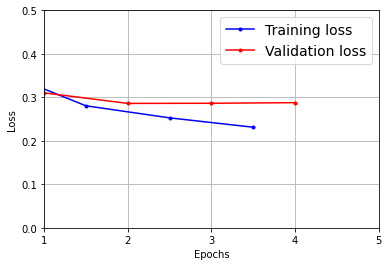

In [ ]:
import matplotlib as mpl
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()